In [1]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import collections
import os.path as osp
import PIL.Image
import scipy.io
from torch.utils import data
import matplotlib.pyplot as plt
import fcn

import os
from torchvision.datasets.vision import VisionDataset
from PIL import Image
from typing import Any, Callable, Dict, Optional, Tuple, List
from torchvision.datasets.sbd import  verify_str_arg,download_and_extract_archive
import torchvision.transforms as transforms


In [2]:

base_dir = 'D:/VOCtrainval_25-May-2011/TrainVal/VOCdevkit/VOC2011/'

root= 'D:/VOCtrainval_25-May-2011/TrainVal/VOCdevkit/VOC2011/'

In [3]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [4]:
class _VOC_Seg_Base(VisionDataset):
    _SPLITS_DIR: str
    _TARGET_DIR: str
    _TARGET_FILE_EXT: str

    def __init__(
        self,
        root: str,
        image_set: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, transforms, transform, target_transform)
        
        valid_image_sets = ["train", "trainval", "val"]
        
        self.image_set = verify_str_arg(image_set, "image_set", valid_image_sets)

        
        splits_dir = os.path.join(root, "ImageSets", self._SPLITS_DIR)
        split_f = os.path.join(splits_dir, image_set.rstrip("\n") + ".txt")
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        image_dir = os.path.join(root, "JPEGImages")
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]

        target_dir = os.path.join(root, self._TARGET_DIR)
        self.targets = [os.path.join(target_dir, x + self._TARGET_FILE_EXT) for x in file_names]

        assert len(self.images) == len(self.targets)

    def __len__(self) -> int:
        return len(self.images)

    def lbl_transform(self,  lbl):
        
        lbl = torch.from_numpy(lbl).to(torch.int64)
        return  lbl



class VOC_Seg_2012(_VOC_Seg_Base):
    _SPLITS_DIR = "Segmentation"
    _TARGET_DIR = "SegmentationClass"
    _TARGET_FILE_EXT = ".png"

    @property
    def masks(self) -> List[str]:
        return self.targets


    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        # img = Image.open(self.images[index])
        
        # img = np.array(img, dtype='f')


        # target = Image.open(self.masks[index])
        
        # target = np.array(target,'f')
        # target[target == 255] = -1

        # load image
        
        img = PIL.Image.open(self.images[index])
        img = np.array(img, dtype=np.uint8)
        # load label
        
        target = PIL.Image.open(self.masks[index])
        target = np.array(target, dtype=np.int32)
        target[target == 255] = -1

        #img = Image.open(self.images[index]).convert("RGB")
        #target = Image.open(self.masks[index])

        target = np.array(target)




        if self.transforms is not None:
            img = self.transforms(img)
            target =self.lbl_transform(target)

        return img, target

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

In [6]:
dataset_train = VOC_Seg_2012(root, 'train', transforms=transform)

dataset_val = VOC_Seg_2012(root, 'val', transforms=transform)

#dataset_train.transforms=transform
#dataset_val.transforms=transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=1, shuffle=False)

In [7]:
class FCN8s(nn.Module):
    
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)


    def forward(self, x):
        input_ = x
        input_ = F.relu(self.conv1_1(input_))
        input_ = F.relu(self.conv1_2(input_))
        input_ = self.pool1(input_)

        input_ = F.relu(self.conv2_1(input_))
        input_ = F.relu(self.conv2_2(input_))
        input_ = self.pool2(input_)

        input_ = F.relu(self.conv3_1(input_))
        input_ = F.relu(self.conv3_2(input_))
        input_ = F.relu(self.conv3_3(input_))
        input_ = self.pool3(input_)
        pool3 = input_  # 1/8

        input_ = F.relu(self.conv4_1(input_))
        input_ = F.relu(self.conv4_2(input_))
        input_ = F.relu(self.conv4_3(input_))
        input_ = self.pool4(input_)
        pool4 = input_  # 1/16

        input_ = F.relu(self.conv5_1(input_))
        input_ = F.relu(self.conv5_2(input_))
        input_ = F.relu(self.conv5_3(input_))
        input_ = self.pool5(input_) # for 32x upsampling 

        input_ = F.relu(self.fc6(input_))
        input_ = self.drop6(input_)

        input_ = F.relu(self.fc7(input_))
        input_ = self.drop7(input_)

        input_ = self.score_fr(input_)
        input_ = self.upscore2(input_)
        upscore2 = input_  # 1/16

        input_ = self.score_pool4(pool4)
        input_ = input_[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = input_  # 1/16

        input_ = upscore2 + score_pool4c  # 1/16
        input_ = self.upscore_pool4(input_)
        upscore_pool4 = input_  # 1/8

        input_ = self.score_pool3(pool3)
        input_ = input_[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]
              ]
        score_pool3c = input_  # 1/8

        input_ = upscore_pool4 + score_pool3c  # 1/8

        input_ = self.upscore8(input_)
        output = input_[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return output

In [8]:
def criterion(input, target):
    loss = torch.nn.NLLLoss()
    
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)

    log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # log_p = log_p.type(torch.LongTensor)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    l = loss(log_p, target)
    if True:
        l /= mask.data.sum()
    return l

In [9]:
EPOCHS = 3
CLASSES = 21
MINI_BATCH=20

In [10]:
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #cuda = torch.cuda.is_available()
    model8 = FCN8s()
    model8.to(device)
    optimizer = optim.Adagrad(model8.parameters(), lr=1e-4)
    #if cuda:
    #    model8 = model8.cuda()
    

    for i in range(EPOCHS):
        for _ in range(int(len(dataset_train)/20)): # 1400 20*1400 *3 
            for _ in range(MINI_BATCH):
              model8.train()
              
              data, label = next(iter(train_loader))
              
              data,label = data.to(device),label.to(device)
              
              data, label = torch.autograd.Variable(data), torch.autograd.Variable(label)
              
              output = model8(data)
              

              loss = criterion(output, label)
              loss.to(device)
              loss.backward()

              #loss = torch.nn.CrossEntropyLoss(output, label)
              
              
          
            
            optimizer.step() # 1 step after 70 images (update)
            optimizer.zero_grad()

            
            
            
        ### Validation ###
        model8.eval()
        data_val, label_val = next(iter(val_loader))
        
        data_val, label_val = data_val.to(device), label_val.to(device)
        
        data_val, label_val = torch.autograd.Variable(data_val), torch.autograd.Variable(label_val)
        with torch.no_grad():
            pred = model8(data_val)
        loss_val = criterion(pred, label_val)
        print(f"Vallidation loss: {loss_val}")
        pred = pred.data.max(1)[1].cpu().numpy()[:,:,:]
        label_val = label_val.data.cpu().numpy()
        acc, acc_cls, mean_iu, _ = label_accuracy_score(label_val, pred, CLASSES)
        print(f"Accuracy: {acc}, class accuracy: {acc_cls}, mean IU: {mean_iu}")


        print(f"Epoch {i} training loss:{loss.data.item()}")

Vallidation loss: 8.198668183467817e-06
Accuracy: 0.8017333600297475, class accuracy: 0.4870680067839964, mean IU: 0.08055443791743784
Epoch 0 training loss:1.2319276720518246e-05
Vallidation loss: 7.5840644058189355e-06
Accuracy: 0.8230199365006722, class accuracy: 0.5, mean IU: 0.4115099682503361
Epoch 1 training loss:4.623075255949516e-06
Vallidation loss: 7.580231795145664e-06
Accuracy: 0.8230199365006722, class accuracy: 0.5, mean IU: 0.4115099682503361
Epoch 2 training loss:2.522153954487294e-05


In [11]:
torch.save(model8.state_dict(), 'C:/Users/준영/vscode storage/model8_dict.pth')
model1 = torch.load('model8.pt')
if torch.cuda.is_available():
    model1.cuda()
model1.eval()

FCN8s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3)

In [12]:
image_file_path = "C:/Users/준영/vscode storage/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [높이][폭][색RGB]

In [16]:
import torchvision.transforms as TF
trf= TF.Compose([TF.Resize(256), TF.CenterCrop(224), TF.ToTensor(), TF.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

input_image = trf(img).unsqueeze(0)
input_image = input_image.cuda()
print(input_image.shape)

torch.Size([1, 3, 224, 224])


In [17]:
out = model1(input_image).cuda()
print(out.shape)

torch.Size([1, 21, 224, 224])


In [21]:
img=data_val[0]

In [22]:
img = img.cpu().numpy()
img = img.transpose(1, 2, 0)

In [23]:
img.shape

(366, 500, 3)

In [24]:
lbl = label_val[0].cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [25]:
pred = pred.data.max(1)[1].cpu().numpy()[:,:,:]

AttributeError: 'memoryview' object has no attribute 'max'

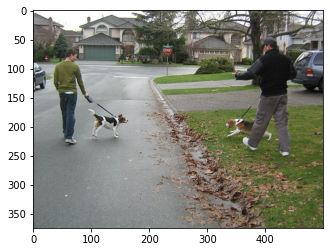

In [35]:
plt.imshow(img)

In [36]:
pred.shape, lbl.shape

((1, 375, 500), (375, 500))

In [37]:
viz = fcn.utils.visualize_segmentation(lbl_pred=pred.reshape((375, 500)), lbl_true=lbl.reshape((375, 500)), img=img, n_class=21)

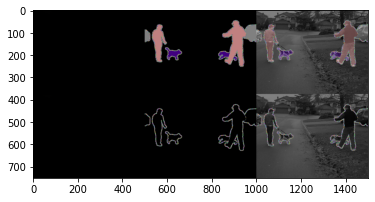

In [38]:
plt.imshow(viz)